# Music recommender system

One of the most used machine learning algorithms is recommendation systems. A **recommender** (or recommendation) **system** (or engine) is a filtering system which aim is to predict a rating or preference a user would give to an item, eg. a film, a product, a song, etc.

Which type of recommender can we have?   

There are two main types of recommender systems: 
- Content-based filters
- Collaborative filters
  
> Content-based filters predicts what a user likes based on what that particular user has liked in the past. On the other hand, collaborative-based filters predict what a user like based on what other users, that are similar to that particular user, have liked.

We have previously developed a content-based recommendation system. Now, we'll look into collaborative filtering. 

### 2) Collaborative filters

Collaborative Filters work with an interaction matrix, also called rating matrix. The aim of this algorithm is to learn a function that can predict if a user will benefit from an item - meaning the user will likely buy, listen to, watch this item.

Among collaborative-based systems, we can encounter two types: **user-item** filtering and **item-item** filtering. 
  
We'll go through the steps for generating a music recommender system. This time, we are going to use a matrix factorization approach. 

### Importing required libraries

First, we'll import all the required libraries.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
conda install -c conda-forge scikit-surprise

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\jakku\anaconda3

  added / updated specs:
    - scikit-surprise


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.5.30  |       h5b45459_0         171 KB  conda-forge

Note: you may need to restart the kernel to use updated packages.
    certifi-2021.5.30          |   py38haa244fe_0         142 KB  conda-forge
    conda-4.10.1               |   py38haa244fe_0         3.1 MB  conda-forge
    openssl-1.1.1k             |       h8ffe710_0         5.7 MB  conda-forge
    python_abi-3.8             |           1_cp38           4 KB  conda-forge
    scikit-surprise-1.1.1      |   py38h1e00858_1         567 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         9.7 MB

The following NEW packages wil

In [2]:
from scipy.sparse import csr_matrix

In [25]:
from surprise import SVD
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

### Reading the files

We are going to use again the **[Million Song Dataset](http://millionsongdataset.com/)**, the freely-available collection of audio features and metadata for a million contemporary popular music tracks that we used for `kNN approach`. 

In [26]:
#df=pd.read_csv('kaggle_visible_evaluation_triplets.txt',sep='\t', names=['user_id','song_id','frequency'])
df=pd.read_csv(r'C:\Users\jakku\Desktop\Data Science assignments\DS Project\kaggle\kaggle_visible_evaluation_triplets.txt',sep='\t',names=['user_id','song_id','frequency'])


In [27]:
#df1=pd.read_csv('unique_tracks.txt',sep='<SEP>',names=['track_id', 'song_id', 'artist_name', 'release'])
df1=pd.read_csv(r'C:\Users\jakku\Desktop\Data Science assignments\DS Project/kaggle/unique_tracks.txt',sep='<SEP>',names=['track_id', 'song_id', 'artist_name', 'release'])

<ipython-input-27-94a105af7ca4>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df1=pd.read_csv(r'C:\Users\jakku\Desktop\Data Science assignments\DS Project/kaggle/unique_tracks.txt',sep='<SEP>',names=['track_id', 'song_id', 'artist_name', 'release'])


In [28]:
df_songs = pd.merge(df, df1.drop_duplicates(['song_id']), on='song_id', how='inner')

In [29]:
df_songs.head()

,user_id,song_id,frequency,track_id,artist_name,release
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One
1,c34670d9c1718361feb93068a853cead3c95b76a,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One
2,c5006d9f41f68ccccbf5ee29212b6af494110c5e,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One
3,e4332e11f4df6dd26673bb6b085e9a2bbdc9b8a5,SOBONKR12A58A7A7E0,2,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One
4,baf2fe5885ab93fbbdb7fecc6691788e70afb6c8,SOBONKR12A58A7A7E0,4,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One


### Prepare the data

We have explored this data before. We know that a user listens to an average of 26 songs. Let's answer one question before continuing. 

**How many users listen to the same song on average?**

In [30]:
song_user = df_songs.groupby('song_id')['user_id'].count()

C:\Users\jakku\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


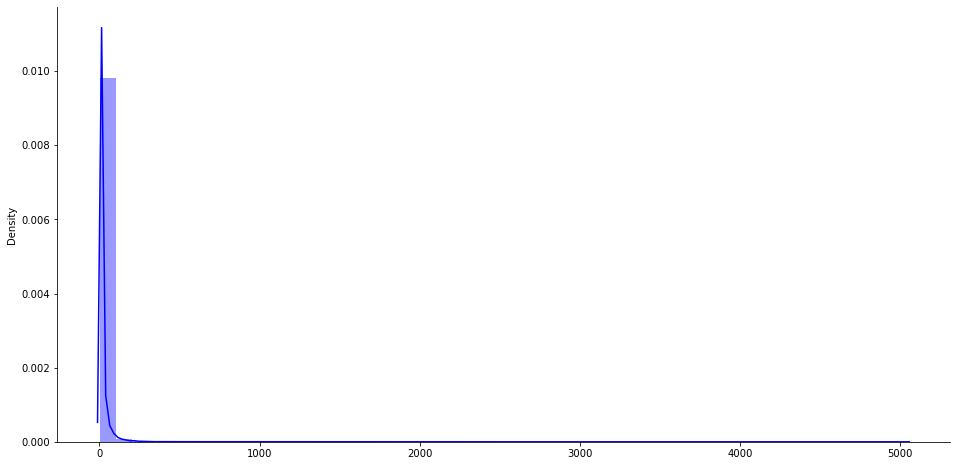

In [31]:
plt.figure(figsize=(16, 8))
sns.distplot(song_user.values, color='blue')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

In [32]:
print(f"A song is listened for an average of {np.mean(song_user)} users, with minimum {np.min(song_user)} and maximum {np.max(song_user)} users")

A song is listened for an average of 8.890193987966128 users, with minimum 1 and maximum 5043 users


So we already know that it is a very sparse matrix. Dealing with such a sparse matrix, we'll take a lot of memory and resources. To make our life easier, let's just select again all those users that have listened to at least 16 songs. Moreover, we are going to select only those songs which have been listened to by at least 200 users.

In [33]:
# Get how many songs each user have listened to
user_counts = df_songs.groupby('user_id')['song_id'].count()

# Filter users which have listen to at least 16 songs
user_ten_id = user_counts[user_counts > 16].index.to_list()

In [34]:
# Get how many user have listened to each song
song_counts = df_songs.groupby('song_id')['user_id'].count()

# Get songs which have been listened at least 4 times
song_ten_id = song_counts[song_counts > 200].index.to_list()

In [35]:
# Filtered the dataset to keep only those users with more than 16 listened
df_song_reduced = df_songs[(df_songs['user_id'].isin(user_ten_id)) & (df_songs['song_id'].isin(song_ten_id))].reset_index(drop=True)

In [36]:
df_song_reduced.shape

(131145, 6)

### Model and recommendations

Matrix Factorization is a powerful way to implement a recommendation system. The idea behind it is to represent users and items in a lower-dimensional latent space. 

So, in other words, Matrix factorization methods decompose the original sparse user-item matrix into lower dimensionality less sparse rectangular matrices with latent features.

This does not only solve the sparsity issue but also makes the method scalable. It doesn't matter how big the matrix is, you can always find lower dimensionality matrices that are a true representation of the original one.

Among the different matrix factorization techniques, we found the popular singular value decomposition (SVD).

This can be an abstract concept as we deepen into the mathematical foundations. But we'll try to keep it as simple as possible.
Imagine we have a matrix A that contains the data for n users x m songs. This matrix can be decomposed uniquely into 3 matrices; let's called them U, S, and V. 

In terms of our song recommender:

- U is an n users x r user-latent feature matrix
- V is an m songs x r song-latent feature matrix
- S is an r x r non-negative diagonal matrix containing the singular values of the original matrix.

Instead of working with the implicit rating as it is, we'll apply the binning technique.  
  
We'll define 10 categories. The original data values which fall into the interval from 0 to 1, will be replaced by the representative rating of 1; if they fall into the interval 1 to 2, they will be replaced by 2; and so on and so forth. The last category will be assigned to original values ranging from 9 to 2213.

In [37]:
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 2214]

In [38]:
df_song_reduced['frequency'] = pd.cut(df_song_reduced['frequency'], bins=bins, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [39]:
listen_counts = pd.DataFrame(df_song_reduced.groupby('frequency').size(), columns=['count']).reset_index(drop=False)

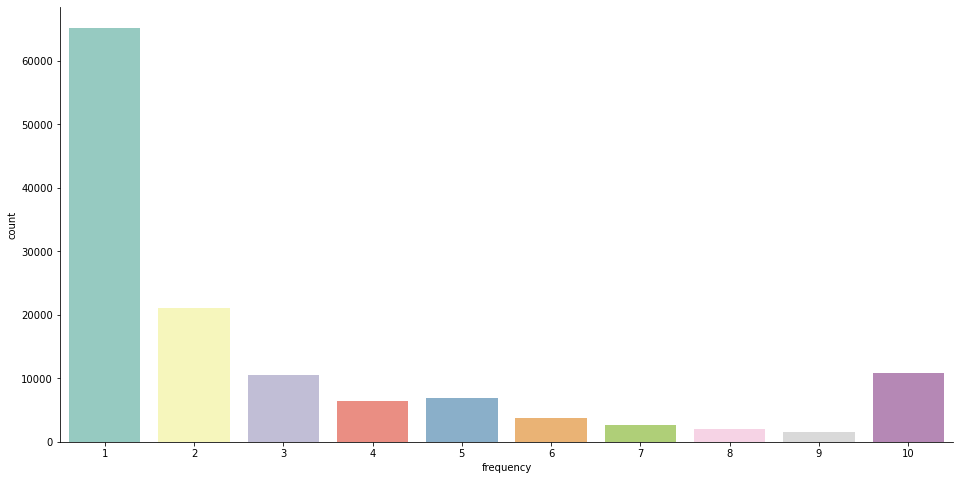

In [40]:
plt.figure(figsize=(16, 8))
sns.barplot(x='frequency', y='count', palette='Set3', data=listen_counts)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

For this topic, we are going to use a fun package called `surprise`. Surprise is an easy-to-use Python library specially designed for recommender systems. 

To load a dataset from our DataFrame, we will use the load_from_df() method.

We will need to pass the following parameters:  

   - df: The dataframe containing the ratings. It must have three columns, corresponding to the user ids, the song ids, and the ratings.
   - reader (Reader): A reader to read the file. Only the rating_scale field needs to be specified.

In [41]:
from surprise import Dataset
from surprise import Reader
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df_song_reduced[['user_id', 'song_id', 'frequency']], reader)

And as always, we split the set into training and testing.

In [42]:
trainset, testset = train_test_split(data, test_size=.25)

We'll use the built-in function for SVD. First, a set of parameters is going to be defined to search for the best parameters for the model. 

The `GridSearchCV` class will compute accuracy metrics for the SVDalgorithm on the combinations of parameters selected, over a cross-validation procedure. This is useful for finding the best set of parameters for a prediction algorithm.

In [43]:
param_grid = {'n_factors': [160], 
              'n_epochs': [100], 
              'lr_all': [0.001, 0.005],
              'reg_all': [0.08, 0.1]}

In [44]:
grid_search_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, joblib_verbose=4, n_jobs=-2)

In [45]:
# find the best parameters for the model
grid_search_svd.fit(data)
find_algo = grid_search_svd.best_estimator['rmse']
print(grid_search_svd.best_score['rmse'])
print(grid_search_svd.best_params['rmse'])

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 out of  12 | elapsed:  1.7min remaining:  5.1min
[Parallel(n_jobs=-2)]: Done   7 out of  12 | elapsed:  1.9min remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  12 out of  12 | elapsed:  3.0min finished


2.5418133492174304
{'n_factors': 160, 'n_epochs': 100, 'lr_all': 0.005, 'reg_all': 0.1}


In [46]:
# Perform the cross validation
cross_validate(find_algo, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.5268  2.5079  2.4889  2.5394  2.5199  2.5166  0.0172  
Fit time          50.09   49.06   52.62   52.79   53.77   51.67   1.78    
Test time         0.19    0.19    0.22    0.30    0.24    0.23    0.04    


{'test_rmse': array([2.52683646, 2.50787558, 2.4889477 , 2.53938823, 2.51989694]),
 'fit_time': (50.09441328048706,
  49.05782341957092,
  52.61658811569214,
  52.786970376968384,
  53.77216911315918),
 'test_time': (0.19480681419372559,
  0.19293498992919922,
  0.22244787216186523,
  0.30008959770202637,
  0.23594450950622559)}

After finding the best parameters for the model, we create our final model, train it and find the error for the test set.

In [47]:
final_algorithm = SVD(n_factors=160, n_epochs=100, lr_all=0.005, reg_all=0.1)
final_algorithm.fit(trainset)
test_predictions = final_algorithm.test(testset)
print(f"The RMSE is {accuracy.rmse(test_predictions, verbose=True)}")

RMSE: 2.5285
The RMSE is 2.5284630828004357
